This notebook produces figure 12 of de Sá, Bernardo et al. (2024).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy.interpolate import UnivariateSpline
from scipy.stats import mode

import gc 
import sys
sys.path.append('..')
from src.utils import sample_histogram
from src.sampling import RandomSampling
from src.imf import IGIMF, Star
from src.constants import DATA_PATH, COMPACT_OBJ_DIR_PATH

In [2]:
plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [3]:
cm_cubehelix = sns.cubehelix_palette(as_cmap=True)

In [23]:
IGIMF_ZAMS_DIR_PATH

PosixPath('/home/lucasmdesa/GitHub/BOSSA/data/2023_igimf_zams_samples')

In [4]:
IGIMF_ZAMS_DIR_PATH = Path(DATA_PATH, '2023_igimf_zams_samples')
ONLYBIN_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_1222_zams_grid')
ALLMULT_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_1212_zams_grid')
ONLYBIN_CANON_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_2122_zams_grid')
ALLMULT_CANON_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_2112_zams_grid')

In [5]:
onlybin_sample_paths = list(ONLYBIN_SAMPLE_DIR_PATH.glob('*.parquet'))
allmult_sample_paths = list(ALLMULT_SAMPLE_DIR_PATH.glob('*.parquet'))
onlybin_canon_sample_paths = list(ONLYBIN_CANON_SAMPLE_DIR_PATH.glob('*.parquet'))
allmult_canon_sample_paths = list(ALLMULT_CANON_SAMPLE_DIR_PATH.glob('*.parquet'))
#sample_paths = list(CO_DIR_PATH.glob('*.parquet'))

In [6]:
def normalize_igimf(igimf_x, igimf_y, sample_x, sample_y):
    igimf_spline = UnivariateSpline(igimf_x, igimf_y, k=3)
    sample_spline = UnivariateSpline(sample_x, sample_y, k=3)
    
    igimf_area = igimf_spline.integral(0.8, 150)
    sample_area = sample_spline.integral(0.8, 150)
    
    print(sample_area, igimf_area)
    
    igimf_norm = sample_area/igimf_area
    
    return igimf_norm

In [7]:
def kroupa_imf(m):
    if m < 0.5:
        return 2*m**-1.3
    else:
        return m**-2.3

In [8]:
def plot_imf(ax, sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 10), legend=True, kroupa=True, mindex=[0], c=None, title=True):
    m1arr = np.sort(sample_df['Mass_ZAMS1_Found'].to_numpy())
    m2arr = np.sort(sample_df['Mass_ZAMS2_Found'].to_numpy())
    m3arr = np.sort(sample_df['Mass_ZAMS3_Found'].to_numpy())
    m4arr = np.sort(sample_df['Mass_ZAMS4_Found'].to_numpy())
    m5arr = np.sort(sample_df['Mass_ZAMS5_Found'].to_numpy())
    m12arr = np.sort(np.concatenate((m1arr, m2arr)))
    mall_arr = np.sort(np.concatenate((m1arr, m2arr, m3arr, m4arr, m5arr)))
    
    m2arr = m2arr[m2arr >= 0.8]
    m3arr = m3arr[m3arr >= 0.8]
    m4arr = m4arr[m4arr >= 0.8]
    m5arr = m5arr[m5arr >= 0.8]
    m12arr = m12arr[m12arr >= 0.8]
    mall_arr = mall_arr[mall_arr >= 0.8]
    

    
    highmass_frac_m1 = len(m1arr[m1arr>=16])/len(m1arr)
    highmass_frac_m2 = len(m2arr[m2arr>=16])/len(m2arr)
    
    sfr = 10**float(sample_descr_dict['logsfr'])
    feh = float(sample_descr_dict['feh'])
    
    igimf = IGIMF(sfr, feh)
    igimf.set_clusters()
    igimf_masses = np.concatenate((np.logspace(np.log10(0.8), np.log10(149.9), 20), [150]))
    igimfs = np.array([igimf.imf(mass) for mass in igimf_masses])
    
    igimf_ip = UnivariateSpline(igimf_masses, igimfs)
    igimf_norm = igimf_ip.integral(5, 150)
    #ax.plot(m1_IMF[:,0][::2], m1_IMF[:,1][::2], 'r-', label='M1')
    #ax.plot(m2_IMF[:,0][::2], m2_IMF[:,1][::2], 'b-', label='M2')
   #ax.plot(m12_IMF[:,0][::2], m12_IMF[:,1][::2], 'g-', label='M1+M2')
   
    m1h, m1b = np.histogram(m1arr, density=True, bins=bins)
    m2h, m2b = np.histogram(m2arr, density=True, bins=bins)
    m3h, m3b = np.histogram(m3arr, density=True, bins=bins)
    m4h, m4b = np.histogram(m4arr, density=True, bins=bins)
    m5h, m5b = np.histogram(m5arr, density=True, bins=bins)
    m12h, m12b = np.histogram(m12arr, density=True, bins=bins)
    mall_h, mall_b = np.histogram(mall_arr, density=True, bins=bins)
    
    m1c = np.array([(m1b0+m1b1)/2 for m1b0, m1b1 in zip(m1b[:-1], m1b[0:])])
    m2c = np.array([(m2b0+m2b1)/2 for m2b0, m2b1 in zip(m2b[:-1], m2b[0:])])
    m3c = np.array([(m3b0+m3b1)/2 for m3b0, m3b1 in zip(m3b[:-1], m3b[0:])])
    m4c = np.array([(m4b0+m4b1)/2 for m4b0, m4b1 in zip(m4b[:-1], m4b[0:])])
    m5c = np.array([(m5b0+m5b1)/2 for m5b0, m5b1 in zip(m5b[:-1], m5b[0:])])
    m12c = np.array([(m12b0+m12b1)/2 for m12b0, m12b1 in zip(m12b[:-1], m12b[0:])])
    mall_c = np.array([(mall_b0+mall_b1)/2 for mall_b0, mall_b1 in zip(mall_b[:-1], mall_b[0:])])
    
    mplots = [[m1b, m1h, 'r', '--', 2, r'$m_1$'],
             [m2b, m2h, 'b', '--', 2, r'$m_2$'],
             [m3b, m3h, 'm', '--', 2, r'$m_3$'],
             [m4b, m4h, 'y', '--', 2, r'$m_4$'],
             [m5b, m5h, 'c', '--', 2, r'$m_5$'],
             [m12b, m12h, 'g', '-', 3, r'$m_1+m2$'],
             [mall_b, mall_h, 'g', '-', 3, r'all $m_i$']]
    for index in mindex:
        mb, mh, color, ls, lw, label = mplots[index]
        if c is not None:
            color = c
        #ax.plot(mc, mh, c=color, ls=ls, label=label, lw=lw)
        ax.stairs(mh, mb, color=color, ls=ls, lw=lw, label=label)
    #ax.plot(m1c, m1h, 'r:', label=r'$m_1$', lw=3)
    #ax.plot(m2c, m2h, 'b:', label=r'$m_2$', lw=3)
    #ax.plot(m3c, m3h, 'm:', label=r'$m_3$', lw=3)
    #ax.plot(m4c, m4h, 'y:', label=r'$m_4$', lw=3)
    #ax.plot(m5c, m5h, 'c:', label=r'$m_5$', lw=3)
    #ax.plot(m12c, m12h, 'g--', label=r'$m_1+m_2$', lw=3)
    #ax.plot(mall_c, mall_h, 'g-', label=r'$\sum_{i=1}^5 m_i$', lw=3)
    
#    sns.histplot(sample_df, x='Mass_ZAMS1_Found', stat='frequency', color='r', label='m1')
#    sns.histplot(sample_df, x='Mass_ZAMS2_Found', stat='frequency', color='b', label='m2')
#    sns.histplot(x=m12arr, stat='frequency', color='g', label='m1+m2')
#    sns.histplot(x=igimf_masses, stat='frequency', color='m', label='IGIMF')
    if not kroupa:
        color = 'k'
        if c is not None:
            color = c
        ax.plot(igimf_masses, igimfs/igimf_norm, color=color, ls='-', label='IGIMF', lw=2)
    
    if kroupa:
        kroupa_masses = np.logspace(np.log10(0.8), np.log10(150), 10)
        kroupa_imfs = np.array([kroupa_imf(m) for m in kroupa_masses])
        kroupa_ip = UnivariateSpline(kroupa_masses, kroupa_imfs)
        kroupa_norm = kroupa_ip.integral(0.08, 150)/10
        ax.plot(kroupa_masses, kroupa_imfs/kroupa_norm, 'k--', label='Kroupa', lw=3)
    if legend:
        ax.legend(loc='upper right', bbox_to_anchor=(1,1), frameon=False)
    
    if title:
        ax.set_title(f'$\log \mathrm{{SFR}} = {sample_descr_dict["logsfr"]}, \mathrm{{[Fe/H]}} = {sample_descr_dict["feh"]}$')
    
    #ax.text(0.2, 0.1, f'M1 hmass frac = {highmass_frac_m1:.4f} \n M2 hmass frac = {highmass_frac_m2:.4f}', transform=ax.transAxes)

    #ax.set_ylim(1e0, 1e8)

    ax.set_xscale('log')
    ax.set_yscale('log')
    
    return mplots

<>:93: SyntaxWarning: invalid escape sequence '\l'
<>:93: SyntaxWarning: invalid escape sequence '\m'
<>:93: SyntaxWarning: invalid escape sequence '\l'
<>:93: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_35594/1358245172.py:93: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f'$\log \mathrm{{SFR}} = {sample_descr_dict["logsfr"]}, \mathrm{{[Fe/H]}} = {sample_descr_dict["feh"]}$')
/tmp/ipykernel_35594/1358245172.py:93: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f'$\log \mathrm{{SFR}} = {sample_descr_dict["logsfr"]}, \mathrm{{[Fe/H]}} = {sample_descr_dict["feh"]}$')


In [9]:
def plot_cdf(ax, sample_df, sample_descr_dict):
    m1arr = np.sort(sample_df['Mass_ZAMS1_Found'].to_numpy())
    m2arr = np.sort(sample_df['Mass_ZAMS2_Found'].to_numpy())
    m3arr = np.sort(sample_df['Mass_ZAMS3_Found'].to_numpy())
    m4arr = np.sort(sample_df['Mass_ZAMS4_Found'].to_numpy())
    m5arr = np.sort(sample_df['Mass_ZAMS5_Found'].to_numpy())
    m12arr = np.sort(np.concatenate((m1arr, m2arr)))
    mall_arr = np.sort(np.concatenate((m1arr, m2arr, m3arr, m4arr, m5arr)))
    
    m2arr = m2arr[m2arr >= 0.8]
    m3arr = m3arr[m3arr >= 0.8]
    m4arr = m4arr[m4arr >= 0.8]
    m5arr = m5arr[m5arr >= 0.8]
    m12arr = m12arr[m12arr >= 0.8]
    mall_arr = mall_arr[mall_arr >= 0.8]
        
    sfr = 10**float(sample_descr_dict['logsfr'])
    feh = float(sample_descr_dict['feh'])
        
    #plt.hist(m1arr, density=True, cumulative=True, label='M1', histtype='step', alpha=1, color='r')
    #plt.hist(m2arr, density=True, cumulative=True, label='M1', histtype='step', alpha=1, color='b')
    #plt.hist(m12arr, density=True, cumulative=True, label='M1', histtype='step', alpha=1, color='g')
    sns.ecdfplot(m1arr, label='M1', color='r', linestyle=':', ax=ax)
    sns.ecdfplot(m2arr, label='M2', color='b', linestyle=':', ax=ax)
    sns.ecdfplot(m12arr, label='M1+M2', color='g', linestyle='--', ax=ax)
    sns.ecdfplot(mall_arr, label=r'$\sum_{i=1}^5 m_i$', color='g', linestyle='-', ax=ax)
    
    igimf = IGIMF(sfr, feh)
    igimf.set_clusters()
    igimf_sampling = RandomSampling(igimf)
    igimf_sampling.compute_imf()
    igimf_sample = igimf_sampling.get_sample(0.8, 150, 100000)
    igimf_sample = igimf_sample[igimf_sample>=0.8]
    sns.ecdfplot(igimf_sample, label='IGIMF', color='m', ax=ax)
    
    k_imf = Star(sfr*1e7, feh, invariant=True)
    k_imf.get_mmax_k()
    k_imf_sampling = RandomSampling(k_imf)
    k_imf_sampling.compute_imf()
    k_imf_sample = k_imf_sampling.get_sample(0.8, 150, 100000)
    k_imf_sample = k_imf_sample[k_imf_sample>=0.8]
    sns.ecdfplot(k_imf_sample, label='Kroupa', color='m', linestyle='--', ax=ax)
    
    ax.legend()
    
    ax.tick_params(axis='both', labelsize=14)

    ax.set_title(f'logSFR = {sample_descr_dict["logsfr"]}, [Fe/H] = {sample_descr_dict["feh"]}', fontsize=14)

    ax.set_xscale('log')

## Redshift plot

#### IMF Grid

In [10]:
onlybin_sample_paths_dict = {}
for path in onlybin_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in onlybin_sample_paths_dict:
        onlybin_sample_paths_dict[z] = []
    onlybin_sample_paths_dict[z].append(path)

In [11]:
allmult_sample_paths_dict = {}
for path in allmult_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in allmult_sample_paths_dict:
        allmult_sample_paths_dict[z] = []
    allmult_sample_paths_dict[z].append(path)

In [12]:
onlybin_canon_sample_paths_dict = {}
for path in onlybin_canon_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in onlybin_canon_sample_paths_dict:
        onlybin_canon_sample_paths_dict[z] = []
    onlybin_canon_sample_paths_dict[z].append(path)

In [13]:
allmult_canon_sample_paths_dict = {}
for path in allmult_canon_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in allmult_canon_sample_paths_dict:
        allmult_canon_sample_paths_dict[z] = []
    allmult_canon_sample_paths_dict[z].append(path)

In [14]:
for z in onlybin_sample_paths_dict:
    unsorted_paths = onlybin_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    onlybin_sample_paths_dict[z] = sorted_paths

In [15]:
for z in allmult_sample_paths_dict:
    unsorted_paths = allmult_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    allmult_sample_paths_dict[z] = sorted_paths

In [16]:
for z in onlybin_canon_sample_paths_dict:
    unsorted_paths = onlybin_canon_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    onlybin_canon_sample_paths_dict[z] = sorted_paths

In [17]:
for z in allmult_canon_sample_paths_dict:
    unsorted_paths = allmult_canon_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    allmult_canon_sample_paths_dict[z] = sorted_paths

In [18]:
from matplotlib.lines import Line2D

In [19]:
plot_zs = sorted(list(onlybin_sample_paths_dict.keys()))[:9]
onlybin_plot_fehs = []
allmult_plot_fehs = []

for z in plot_zs:
        onlybin_sample_paths_ = onlybin_sample_paths_dict[z]   
        allmult_sample_paths_ = allmult_sample_paths_dict[z]   
        for path in onlybin_sample_paths_[:-1]:
                sample_descr = path.name.split('_')[:-3]

                sample_descr_dict = {}
                for attr in sample_descr:
                    key, value = attr.split('=')
                    sample_descr_dict[key] = value
                onlybin_plot_fehs.append(sample_descr_dict['feh'])
        for path in allmult_sample_paths_[:-1]:
                sample_descr = path.name.split('_')[:-3]

                sample_descr_dict = {}
                for attr in sample_descr:
                    key, value = attr.split('=')
                    sample_descr_dict[key] = value
                allmult_plot_fehs.append(sample_descr_dict['feh'])
onlybin_plot_fehs = np.array(onlybin_plot_fehs, np.float32)
allmult_plot_fehs = np.array(allmult_plot_fehs, np.float32)

In [20]:
onlybin_min_plot_feh = onlybin_plot_fehs.min()
onlybin_max_plot_feh = onlybin_plot_fehs.max()
onlybin_norm_plot_feh = onlybin_max_plot_feh - onlybin_min_plot_feh

ValueError: zero-size array to reduction operation minimum which has no identity

In [21]:
allmult_min_plot_feh = allmult_plot_fehs.min()
allmult_max_plot_feh = allmult_plot_fehs.max()
allmult_norm_plot_feh = allmult_max_plot_feh - allmult_min_plot_feh

In [22]:
min_plot_feh = min(onlybin_min_plot_feh, allmult_min_plot_feh)
max_plot_feh = max(onlybin_max_plot_feh, allmult_max_plot_feh)
norm_plot_feh = max_plot_feh - min_plot_feh

In [23]:
plot_zs = np.array(plot_zs)

/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


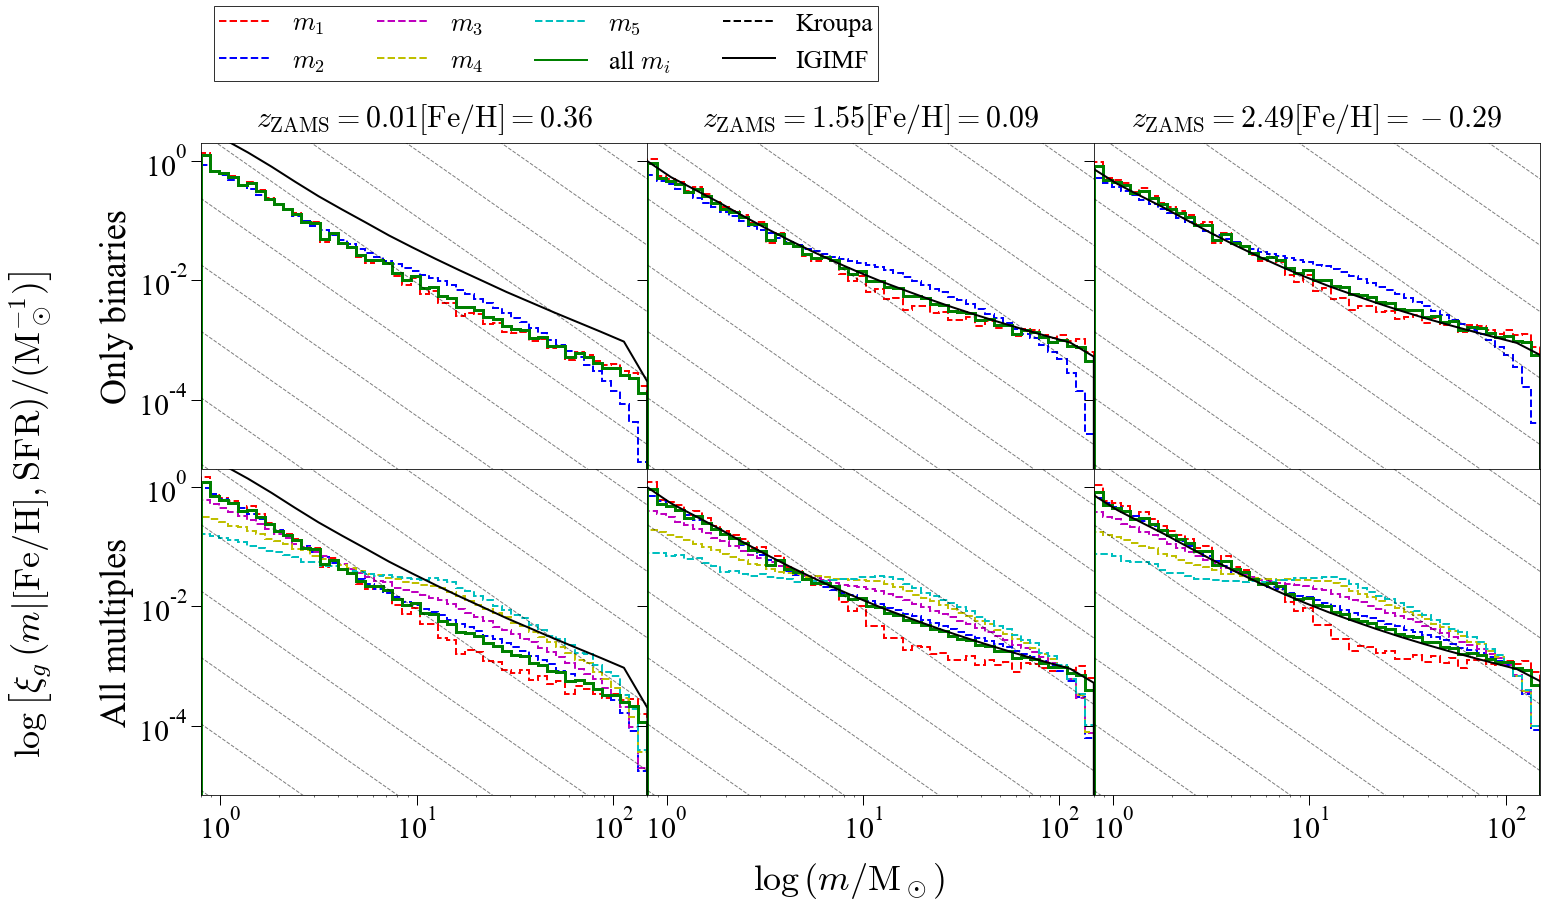

In [50]:
fig, axes_ = plt.subplots(2, 3, figsize=(24, 12), sharex=True, sharey=True)
axes = axes_#.flatten()
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')


for z, ax in zip(plot_zs[[0,5,8]], axes[0]):
    sample_paths_ = onlybin_sample_paths_dict[z]   
    
    for b in np.logspace(-5, 5, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        #ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)
    
    counter = 0
    for path in sample_paths_[[5]]:
        sample_descr = path.name.split('_')[:-3]

        sample_descr_dict = {}
        for attr in sample_descr:
            key, value = attr.split('=')
            sample_descr_dict[key] = value
            
        feh = np.float32(sample_descr_dict['feh'])
        #c = cm.viridis(counter/9)
        c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

        sample_df = pd.read_parquet(path, engine='pyarrow')

        legend = False
        if counter == 0:
            legend = True
            
        plot_imf(ax, sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 50), legend=False, kroupa=False, mindex=[0,1,-1], c=None, title=False)
        counter += 1
        
         #   for ax in axes[-1, :]:
        #ax.set_xlabel(r'$\log\left(M/\mathrm{M}_\odot\right)$', fontsize=18)
        #ax.set_xticks([1e-1, 1e0, 1e1, 1e2])
        #ax.set_xticklabels(['-1', '0', '1', '2'])
    ax.set_xlim(0.8, 150)
    ax.set_ylim(1e-5, 2e0)

    #for ax in axes[:, 0]:
        #ax.set_ylabel(, fontsize=18)
        #ax.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
        #ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8'])
        
    z_descr_str = ''.join([f'$z_\mathrm{{ZAMS}}={z:.2f}$',
                             f'$\mathrm{{[Fe/H]}}={feh:.2f}$'])
    #z_descr = ax.text(0.95, 0.9, z_descr_str, ha='right', va='top', transform=ax.transAxes, fontsize=30)
    #z_descr.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='gray'))
    fig.text(0.5, 1.02, z_descr_str, ha='center', va='bottom', transform=ax.transAxes, fontsize=30)
    
for z, ax in zip(plot_zs[[0,5,8]], axes[1]):
    sample_paths_ = allmult_sample_paths_dict[z]   
    
    for b in np.logspace(-5, 5, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        #ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)
    
    counter = 0
    for path in sample_paths_[[5]]:
        sample_descr = path.name.split('_')[:-3]

        sample_descr_dict = {}
        for attr in sample_descr:
            key, value = attr.split('=')
            sample_descr_dict[key] = value
            
        feh = np.float32(sample_descr_dict['feh'])
        #c = cm.viridis(counter/9)
        c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

        sample_df = pd.read_parquet(path, engine='pyarrow')

        legend = False
        if counter == 0:
            legend = True
            
        plot_imf(ax, sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 50), legend=False, kroupa=False, mindex=[0,1,2,3,4,-1], c=None, title=False)
        counter += 1
        

 #   for ax in axes[-1, :]:
        #ax.set_xlabel(r'$\log\left(M/\mathrm{M}_\odot\right)$', fontsize=18)
        #ax.set_xticks([1e-1, 1e0, 1e1, 1e2])
        #ax.set_xticklabels(['-1', '0', '1', '2'])
    ax.set_xlim(0.8, 150)
    ax.set_ylim(1e-5, 2e0)

    #for ax in axes[:, 0]:
        #ax.set_ylabel(, fontsize=18)
        #ax.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
        #ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8'])
        
    #z_descr_str = '\n'.join([f'$z_\mathrm{{ZAMS}}={z:.2f}$',
    #                         f'$\mathrm{{[Fe/H]}}={feh:.2f}$'])
    #z_descr = ax.text(0.95, 0.95, z_descr_str, ha='right', va='top', transform=ax.transAxes, fontsize=30)
    #z_descr.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='gray'))
    
    
fig.text(0.04, 0.45, r'$\log\left[\xi_g\,\left(m|\mathrm{[Fe/H]},\mathrm{SFR}\right)/(\mathrm{M}_\odot^{-1})\right]$', 
         ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=36)
fig.text(0.5, 0.05, r'$\log\left(m/\mathrm{M}_\odot\right)$', ha='center', va='top', fontsize=36)

#fig.text(0.5, 1, 'All multiples', ha='center', va='bottom', transform=axes[0,1].transAxes, fontsize=36)
#fig.text(0.5, 1, 'All multiples', ha='center', va='bottom', transform=axes[0,2].transAxes, fontsize=36)
fig.text(-0.15, 0.5, 'Only binaries', ha='right', va='center', rotation=90, transform=axes[0,0].transAxes, fontsize=36)
fig.text(-0.15, 0.5, 'All multiples', ha='right', va='center', rotation=90, transform=axes[1,0].transAxes, fontsize=36)

for ax in axes.flatten():
    ax.set_xlim(0.8, 150)
    ax.tick_params(labelsize=30)
    ax.set_ylim(7e-6, 2e0)

mplots = [['r', '--', r'$m_1$'],
         ['b', '--', r'$m_2$'],
         ['m', '--', r'$m_3$'],
         ['y', '--', r'$m_4$'],
         ['c', '--', r'$m_5$'],
         ['g', '-', r'all $m_i$']]

for ax in [axes[0,0]]:
    handles = []
    for mplot in mplots:
        sample_line = Line2D([0], [0], label=mplot[2], color=mplot[0], linestyle=mplot[1])
        handles.append(sample_line)
    igimf_line = Line2D([0], [0], label='IGIMF', color='k',  linestyle='-')
    kroupa_line = Line2D([0], [0], label='Kroupa', color='k', linestyle='--')
    handles += [kroupa_line, igimf_line]
    ax.legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.15), ncol=4, edgecolor='black', fancybox=False, borderpad=0.2)
    
plt.savefig(FIGURE_FOLDER/f'imf_sampling_variations_1e6.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/f'imf_sampling_variations_1e6.png', bbox_inches='tight')

/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


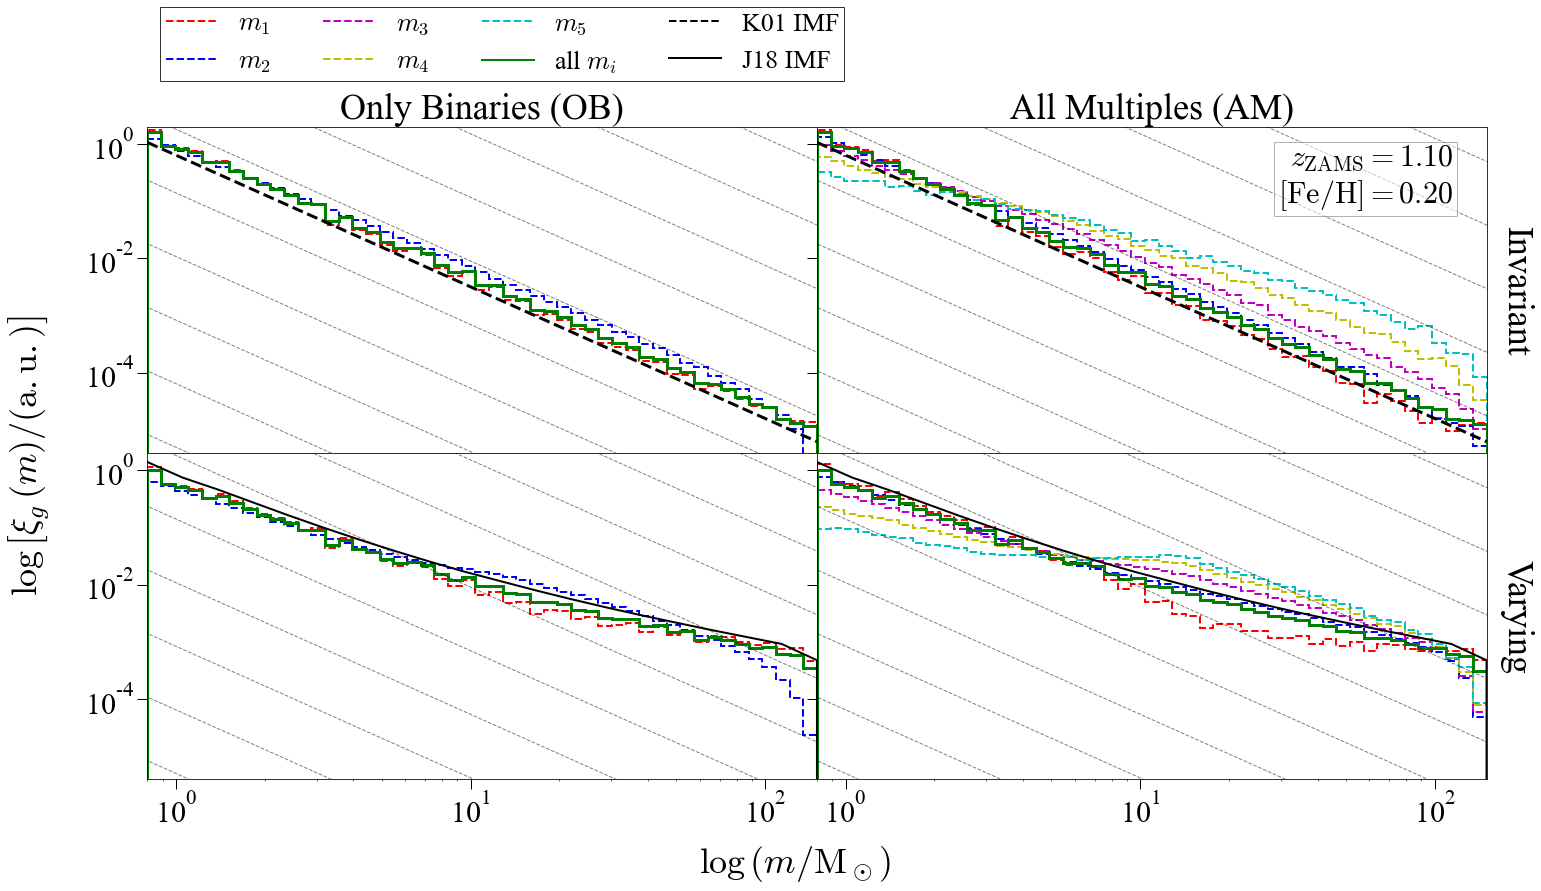

In [26]:
fig, axes_ = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axes = axes_#.flatten()
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

z = plot_zs[3]

######### Q CORR ONLYBIN PLOT ###############
sample_paths_ = onlybin_sample_paths_dict[z]
ax = axes[1,0]

for b in np.logspace(-5, 5, 10):
    ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
    ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)

counter = 0
for path in sample_paths_[[5]]:
    sample_descr = path.name.split('_')[:-3]

    sample_descr_dict = {}
    for attr in sample_descr:
        key, value = attr.split('=')
        sample_descr_dict[key] = value

    feh = np.float32(sample_descr_dict['feh'])
    c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

    sample_df = pd.read_parquet(path, engine='pyarrow')

    legend = False
    if counter == 0:
        legend = True

    corr_onlybin_mplots = plot_imf(ax, sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 50), legend=False, kroupa=False, mindex=[0,1,-1], c=None, title=False)
    counter += 1

ax.set_xlim(0.8, 150)
ax.set_ylim(1e-5, 2e0)

######### Q NOCORR ONLYBIN PLOT ###############
sample_paths_ = onlybin_canon_sample_paths_dict[z]
ax = axes[0,0]

for b in np.logspace(-5, 5, 10):
    ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
    ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)

counter = 0
for path in sample_paths_[[5]]:
    sample_descr = path.name.split('_')[:-3]

    sample_descr_dict = {}
    for attr in sample_descr:
        key, value = attr.split('=')
        sample_descr_dict[key] = value

    feh = np.float32(sample_descr_dict['feh'])
    c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

    sample_df = pd.read_parquet(path, engine='pyarrow')

    legend = False
    if counter == 0:
        legend = True

    nocorr_onlybin_mplots = plot_imf(ax, sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 50), legend=False, kroupa=True, mindex=[0,1,-1], c=None, title=False)
    counter += 1

ax.set_xlim(0.8, 150)
ax.set_ylim(1e-5, 2e0)

#################### Q CORR ALLMULT PLOT ################
sample_paths_ = allmult_sample_paths_dict[z]   
ax = axes[1,1]

for b in np.logspace(-5, 5, 10):
    ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
    ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)

counter = 0
for path in sample_paths_[[5]]:
    sample_descr = path.name.split('_')[:-3]

    sample_descr_dict = {}
    for attr in sample_descr:
        key, value = attr.split('=')
        sample_descr_dict[key] = value

    feh = np.float32(sample_descr_dict['feh'])
    #c = cm.viridis(counter/9)
    c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

    sample_df = pd.read_parquet(path, engine='pyarrow')

    legend = False
    if counter == 0:
        legend = True

    corr_allmult_mplots = plot_imf(ax, sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 50), legend=False, kroupa=False, mindex=[0,1,2,3,4,-1], c=None, title=False)
    counter += 1

ax.set_xlim(0.8, 150)
ax.set_ylim(1e-5, 2e0)

#################### Q NOCORR ALLMULT PLOT ################
sample_paths_ = allmult_canon_sample_paths_dict[z]   
ax = axes[0,1]

for b in np.logspace(-5, 5, 10):
    ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))  
    ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)

counter = 0
for path in sample_paths_[[5]]:
    sample_descr = path.name.split('_')[:-3]

    sample_descr_dict = {}
    for attr in sample_descr:
        key, value = attr.split('=')
        sample_descr_dict[key] = value

    feh = np.float32(sample_descr_dict['feh'])
    c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

    sample_df = pd.read_parquet(path, engine='pyarrow')

    legend = False
    if counter == 0:
        legend = True

    nocorr_allmult_mplots = plot_imf(ax, sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 50), legend=False, kroupa=True, mindex=[0,1,2,3,4,-1], c=None, title=False)
    counter += 1

z_descr_str = '\n'.join([f'$z_\mathrm{{ZAMS}}={z:.2f}$',
                         f'$\mathrm{{[Fe/H]}}={feh:.2f}$'])
z_descr = ax.text(0.95, 0.95, z_descr_str, ha='right', va='top', transform=ax.transAxes, fontsize=30)
z_descr.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='gray'))

############ FINAL DETAILS #############

for ax in axes.flatten():
    ax.set_xlim(0.8, 150)
    ax.set_ylim(4e-6, 2e0)
    ax.tick_params(labelsize=30)
    
fig.text(0.5, 1, 'Only Binaries (OB)', ha='center', va='bottom', transform=axes[0,0].transAxes, fontsize=36)
fig.text(0.5, 1, 'All Multiples (AM)', ha='center', va='bottom', transform=axes[0,1].transAxes, fontsize=36)
fig.text(1.02, 0.5, 'Varying', ha='left', va='center', rotation=-90, transform=axes[1,1].transAxes, fontsize=36)
fig.text(1.02, 0.5, 'Invariant', ha='left', va='center', rotation=-90, transform=axes[0,1].transAxes, fontsize=36)

fig.text(0.07, 0.5, r'$\log\left[\xi_g\,(m)/(\mathrm{a.u.})\right]$', 
         ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=36)
fig.text(0.5, 0.05, r'$\log\left(m/\mathrm{M}_\odot\right)$', ha='center', va='top', fontsize=36)

mplots = [['r', '--', r'$m_1$'],
         ['b', '--', r'$m_2$'],
         ['m', '--', r'$m_3$'],
         ['y', '--', r'$m_4$'],
         ['c', '--', r'$m_5$'],
         ['g', '-', r'all $m_i$']]

for ax in [axes[0,0]]:
    handles = []
    for mplot in mplots:
        sample_line = Line2D([0], [0], label=mplot[2], color=mplot[0], linestyle=mplot[1])
        handles.append(sample_line)
    igimf_line = Line2D([0], [0], label='J18 IMF', color='k',  linestyle='-')
    kroupa_line = Line2D([0], [0], label='K01 IMF', color='k', linestyle='--')
    handles += [kroupa_line, igimf_line]
    ax.legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.1), ncol=4, edgecolor='black', fancybox=False, borderpad=0.2)
    
plt.savefig(FIGURE_FOLDER/f'imf_sampling_comparison_1e6.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/f'imf_sampling_comparison_1e6.png', bbox_inches='tight')

In [52]:
from scipy.stats import linregress

In [59]:
samples_mplots = {'corr_onlybin': corr_onlybin_mplots, 
                  'nocorr_onlybin': nocorr_onlybin_mplots,
                  'corr_allmult': corr_allmult_mplots,
                  'nocorr_allmult': nocorr_allmult_mplots}
mplot_array_labels = ['m1', 'm2', 'm3', 'm4', 'm5', 'm21', 'mall']

for sample_label in samples_mplots:
    mplots = samples_mplots[sample_label]
    for mplot, mplot_label in zip(mplots, mplot_array_labels):
        mb, mh, color, ls, lw, label = mplot
        mb = np.log10(mb)
        mc = np.array([(mb0+mb1)/2 for mb0, mb1 in zip(mb[:-1], mb[1:])])
        mh = np.log10(mh)
        m10_i = np.searchsorted(mc, 1)
        slope, *_ = linregress(mc, mh)
        slope1, *_ = linregress(mc[:m10_i], mh[:m10_i])
        slope2, *_ = linregress(mc[m10_i:], mh[m10_i:])
        print(f'In {sample_label} label, {mplot_label} is best fit by a power-law {slope:.2f}, or {slope1:.2f} up to {10**mc[m10_i]:.2f} Mo and {slope2:.2f} above.')
    print('')

In corr_onlybin label, m1 is best fit by a power-law -1.44, or -1.84 up to 10.95 Mo and -0.89 above.
In corr_onlybin label, m2 is best fit by a power-law -1.52, or -1.49 up to 10.95 Mo and -2.03 above.
In corr_onlybin label, m3 is best fit by a power-law nan, or nan up to 10.95 Mo and nan above.
In corr_onlybin label, m4 is best fit by a power-law nan, or nan up to 10.95 Mo and nan above.
In corr_onlybin label, m5 is best fit by a power-law nan, or nan up to 10.95 Mo and nan above.
In corr_onlybin label, m21 is best fit by a power-law -1.44, or -1.74 up to 10.95 Mo and -1.17 above.
In corr_onlybin label, mall is best fit by a power-law -1.44, or -1.74 up to 10.95 Mo and -1.17 above.

In nocorr_onlybin label, m1 is best fit by a power-law -2.32, or -2.35 up to 10.95 Mo and -2.21 above.
In nocorr_onlybin label, m2 is best fit by a power-law -2.26, or -2.06 up to 10.95 Mo and -2.56 above.
In nocorr_onlybin label, m3 is best fit by a power-law nan, or nan up to 10.95 Mo and nan above.
In n

NameError: name 'sample_paths_dict' is not defined

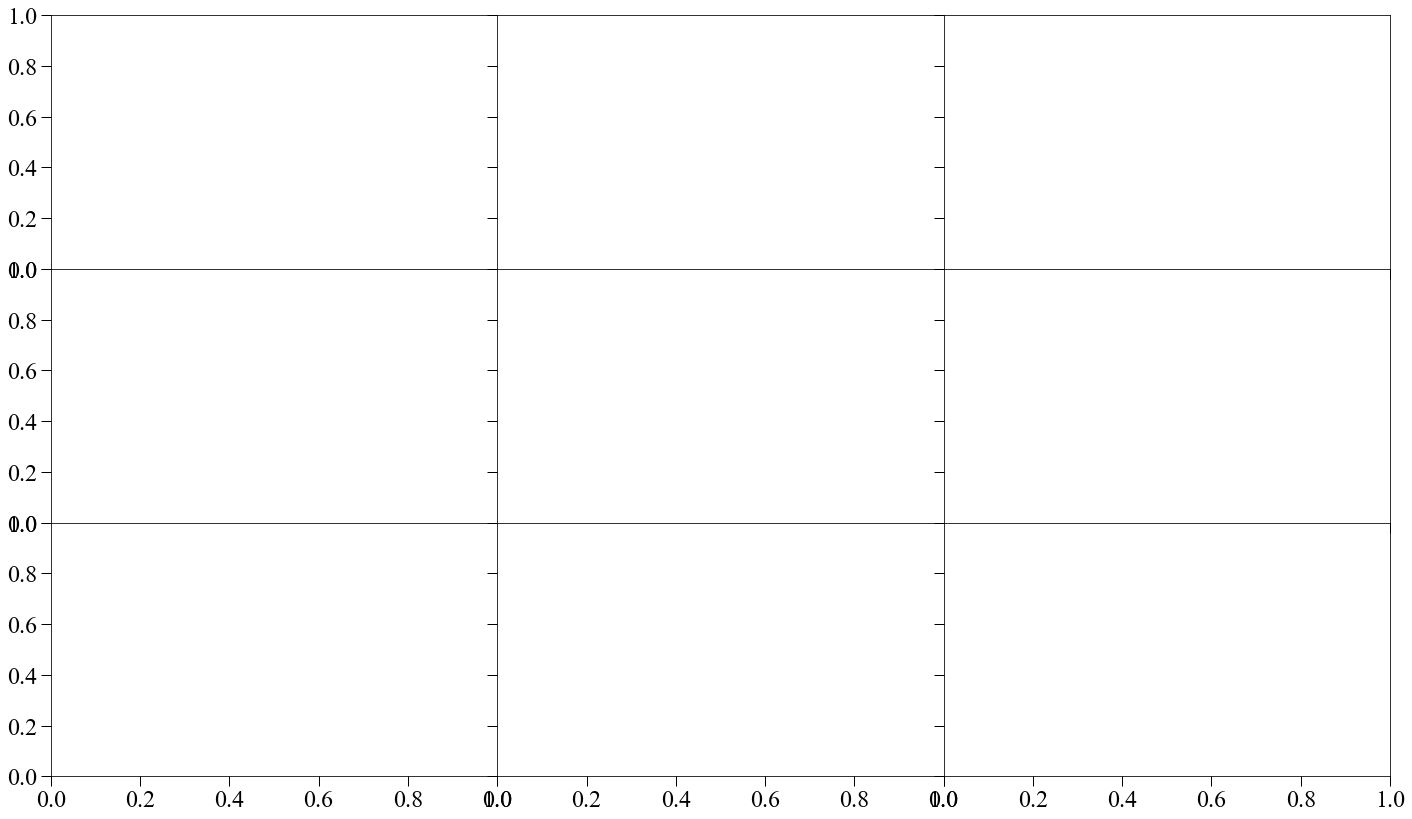

In [177]:
fig, axes_ = plt.subplots(3, 3, figsize=(24, 14), sharex=True, sharey=True)
axes = axes_.flatten()
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')



for z, ax in zip(plot_zs, axes):
    sample_paths_ = sample_paths_dict[z]   
    
    for b in np.logspace(-5, 5, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        #ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)
    
    counter = 0
    for path in sample_paths_[:-1]:
        sample_descr = path.name.split('_')[:-3]

        sample_descr_dict = {}
        for attr in sample_descr:
            key, value = attr.split('=')
            sample_descr_dict[key] = value
            
        feh = np.float32(sample_descr_dict['feh'])
        #c = cm.viridis(counter/9)
        c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

        sample_df = pd.read_parquet(path, engine='pyarrow')

        legend = False
        if counter == 0:
            legend = True
            
        plot_imf(ax, sample_df, sample_descr_dict, np.logspace(np.log10(0.08), np.log10(150), 50), legend=False, kroupa=False, mindex=[1], c=c, title=False)
        counter += 1
        
        

 #   for ax in axes[-1, :]:
        #ax.set_xlabel(r'$\log\left(M/\mathrm{M}_\odot\right)$', fontsize=18)
        #ax.set_xticks([1e-1, 1e0, 1e1, 1e2])
        #ax.set_xticklabels(['-1', '0', '1', '2'])
    ax.set_xlim(0.8, 150)
    ax.set_ylim(1e-5, 2e0)

    #for ax in axes[:, 0]:
        #ax.set_ylabel(, fontsize=18)
        #ax.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
        #ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8'])
        
    z_descr = ax.text(0.95, 0.9, f'$z_\mathrm{{ZAMS}}={z:.2f}$', ha='right', va='top', transform=ax.transAxes, fontsize=30)
    z_descr.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='gray'))
fig.text(0.08, 0.45, r'$\log\left[\xi_g\,\left(m|\mathrm{[Fe/H]},\mathrm{SFR}\right)/(\mathrm{M}_\odot^{-1})\right]$', 
         ha='right', va='center', rotation=90, transform=fig.transFigure)
fig.text(0.5, 0.05, r'$\log\left(m/\mathrm{M}_\odot\right)$', ha='center', va='top')
sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min_plot_feh, vmax=max_plot_feh))
cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
cb.set_label('[Fe/H]')

for ax in axes[[2]]:
    #ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    sample_line = Line2D([0], [0], label='$m_2$', color='k', linestyle=':')
    igimf_line = Line2D([0], [0], label='IGIMF', color='k',  linestyle='-')
    kroupa_line = Line2D([0], [0], label='Kroupa', color='k', linestyle='--')
    handles = [sample_line, kroupa_line, igimf_line]
    ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    
    #plt.savefig(FIGURE_FOLDER/f'imfsample_1e2z{100*z:.2f}.pdf', bbox_inches='tight')
    #plt.savefig(FIGURE_FOLDER/f'imfsample_1e2z{100*z:.2f}.png', bbox_inches='tight')

In [ ]:
fig, axes_ = plt.subplots(3, 3, figsize=(24, 14), sharex=True, sharey=True)
axes = axes_.flatten()
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')



for z, ax in zip(plot_zs, axes):
    sample_paths_ = sample_paths_dict[z]   
    
    for b in np.logspace(-5, 5, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        #ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)
    
    counter = 0
    for path in sample_paths_[:-1]:
        sample_descr = path.name.split('_')[:-3]

        sample_descr_dict = {}
        for attr in sample_descr:
            key, value = attr.split('=')
            sample_descr_dict[key] = value
            
        feh = np.float32(sample_descr_dict['feh'])
        #c = cm.viridis(counter/9)
        c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

        sample_df = pd.read_parquet(path, engine='pyarrow')

        legend = False
        if counter == 0:
            legend = True
            
        plot_imf(ax, sample_df, sample_descr_dict, np.logspace(np.log10(0.8), np.log10(150), 50), legend=False, kroupa=False, mindex=[-1], c=c, title=False)
        counter += 1
        
        

 #   for ax in axes[-1, :]:
        #ax.set_xlabel(r'$\log\left(M/\mathrm{M}_\odot\right)$', fontsize=18)
        #ax.set_xticks([1e-1, 1e0, 1e1, 1e2])
        #ax.set_xticklabels(['-1', '0', '1', '2'])
    ax.set_xlim(0.8, 150)
    ax.set_ylim(1e-5, 2e0)

    #for ax in axes[:, 0]:
        #ax.set_ylabel(, fontsize=18)
        #ax.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
        #ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8'])
        
    z_descr = ax.text(0.95, 0.9, f'$z_\mathrm{{ZAMS}}={z:.2f}$', ha='right', va='top', transform=ax.transAxes, fontsize=30)
    z_descr.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='gray'))
fig.text(0.08, 0.45, r'$\log\left[\xi_g\,\left(m|\mathrm{[Fe/H]},\mathrm{SFR}\right)/(\mathrm{M}_\odot^{-1})\right]$', 
         ha='right', va='center', rotation=90, transform=fig.transFigure)
fig.text(0.5, 0.05, r'$\log\left(m/\mathrm{M}_\odot\right)$', ha='center', va='top')
sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min_plot_feh, vmax=max_plot_feh))
cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
cb.set_label('[Fe/H]')

for ax in axes[[2]]:
    #ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    sample_line = Line2D([0], [0], label='All $m_i$', color='k', linestyle=':')
    igimf_line = Line2D([0], [0], label='IGIMF', color='k',  linestyle='-')
    kroupa_line = Line2D([0], [0], label='Kroupa', color='k', linestyle='--')
    handles = [sample_line, kroupa_line, igimf_line]
    ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    
    #plt.savefig(FIGURE_FOLDER/f'imfsample_1e2z{100*z:.2f}.pdf', bbox_inches='tight')
    #plt.savefig(FIGURE_FOLDER/f'imfsample_1e2z{100*z:.2f}.png', bbox_inches='tight')